In [3]:
from example.discretizer.utils import IsTrafficLightNearby, IsStopSignNearby, IsZebraNearby, LanePosition, FrontLeftObjects, FrontRightObjects, PedestrianNearby, BlockProgress
from pgeon.intention_introspector import IntentionIntrospector
from pgeon.desire import Desire
from pgeon.discretizer import Predicate
from example.discretizer.discretizer_d0 import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
import numpy as np
import matplotlib.pyplot as plt
from typing import Set, Dict, Tuple


## Common initialization (valid for each discretiser)

In [4]:
environment = SelfDrivingEnvironment(city='all')
discretizer_configs = {
    'a': {'obj_discretizer': 'binary', 'vel_discretizer': 'binary' },
    'b': {'obj_discretizer': 'multiple', 'vel_discretizer': 'binary'},
    'c': {'obj_discretizer': 'multiple', 'vel_discretizer': 'multiple'}
    }

default_config = {'obj_discretizer': 'multiple', 'vel_discretizer': 'multiple'}
commitment_threshold = 0.5

In [5]:
def roc_curve(discretisers_info: Dict[str, Tuple[PG.PolicyGraph, Set[Desire]]]):
    
    plt.figure(figsize=(10, 6))

    thresholds = np.arange(0, 1, 0.1)

    for discretizer_id, (pg, desires) in discretisers_info.items():
        intention_probabilities = []
        expected_probabilities = []

        for threshold in thresholds:
            print(threshold)
            ii = IntentionIntrospector(desires, pg)

            intention_prob, expected_prob=ii.get_intention_metrics(commitment_threshold=threshold,desire=any)
            intention_probabilities.append(intention_prob)
            expected_probabilities.append(expected_prob)

        plt.plot(intention_probabilities, expected_probabilities, label=f'Discretizer {discretizer_id}')

        
    plt.xlabel('Intention Probability for ANY desire')
    plt.ylabel('Expected Intention Probability')
    plt.title('Intention Probability vs Expected Intention Probability for Different Discretizers')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
def show_metrics(metrics_data, discretizer_id, type='Desire'):
    """
    Function to show bar plots with metrics for each desire. The metrics can be 
    desire or intention metrics, based on the value of the parameter 'type' (Desire or Intention).
    """

    desires = list(metrics_data.keys())

    fig, ax = plt.subplots(figsize=(20, 10))

    labels = []
    val1 = []
    val2 = []

    for desire in desires:
        if desire == 'any':
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        else:
            val1.append(metrics_data[desire][0])
            val2.append(metrics_data[desire][1])
        labels.append(f"{desire}")

    x = np.arange(len(desires))
    width = 0.35

    rects1 = ax.bar(x - width/2, val1, width, label=f'{type} Probability')
    metric_label = 'Expected Action Prob.' if type == 'Desire' else 'Expected Intention Prob.'
    rects2 = ax.bar(x + width/2, val2, width, label=metric_label)

    ax.set_xlabel(f'Desires')
    ax.set_ylabel(f'{type}s Metrics')
    ax.set_title(f'Discretizer {discretizer_id}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
        
    ax.legend()
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    for rect in rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    plt.show()  

Desires valid for all discretisers

In [7]:
any = Desire("any", None, set())
stop_traffic_light = Desire("stop_traffic_light", [1], {Predicate(IsTrafficLightNearby, [IsTrafficLightNearby.YES])}) #NOTE: traffic light color can be also green or yellow
stop_stop_sign = Desire("stop_stop_sign", [1], {Predicate(IsStopSignNearby, [IsStopSignNearby.YES])})
stop_zebra = Desire("stop_zebra", [1], {Predicate(IsZebraNearby, [IsZebraNearby.YES])})
lane_change = Desire("lane_change", [7,8, 2, 3 ], {Predicate(LanePosition, [LanePosition.CENTER]) }) #GAS_TURN_LEFT
turn_at_intersection = Desire("turn_at_intersection", [7,8, 2, 3 ], {Predicate(BlockProgress, [BlockProgress.INTERSECTION])})


## Discretisers 0a, 0b, 0c

#### Compute Desires and Intention Metrics


In [8]:
intentions_data = {}
desires_data = {}
for discretizer_id in ['0a','0b' ,'0c']:#, '1a','1b','1c']: #
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    discretizer = AVDiscretizer(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
        ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    print(f'DISCRETIZER {discretizer_id} ')
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    obstacle_avoidance_l = Desire("few_left_obstacle_avoid", [3, 7], {Predicate(FrontLeftObjects, [FrontLeftObjects(1, discretization=config['obj_discretizer'])]) })
    obstacle_avoidance_r = Desire("few_right_obstacle_avoid", [2, 8], {Predicate(FrontRightObjects, [FrontRightObjects(1,discretization=config['obj_discretizer'])])})

    desires = [turn_at_intersection, stop_stop_sign, stop_traffic_light, stop_zebra, lane_change, obstacle_avoidance_l, obstacle_avoidance_r]

    if 'a' not in discretizer_id:
        desires.append(Desire("many_left_obstacle_avoid", [3, 7], {Predicate(FrontLeftObjects, [FrontLeftObjects(4, discretization=config['obj_discretizer'])]) }) )
        desires.append(Desire("many_right_obstacle_avoid", [2, 8], {Predicate(FrontRightObjects, [FrontRightObjects(4,discretization=config['obj_discretizer'])])})  )
        #desires.append(Desire("overtake", [1], {Predicate(LanePosition, [LanePosition.CENTER]), Predicate(FrontRightObjects(1)) }))
    #else:
        #desires.append(Desire("overtake", [1], {Predicate(LanePosition, [LanePosition.CENTER]) }))
    ii = IntentionIntrospector(desires, pg)

    desires_data[discretizer_id] = ii.find_desires() 
    print(desires_data[discretizer_id])
    intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
    intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
    print(intentions_data[discretizer_id])
    print()

DISCRETIZER 0a 
{'turn_at_intersection': (0, 0), 'stop_stop_sign': (0.07341237615721945, 0.15221294371929228), 'stop_traffic_light': (0.22083265659682744, 0.4989341484853402), 'stop_zebra': (0.34199556060852143, 0.35371643694873045), 'lane_change': (0.060364896323967306, 0.32632512854799267), 'few_left_obstacle_avoid': (0.7732662010719505, 0.08803686305039558), 'few_right_obstacle_avoid': (0.8144117806290943, 0.07940244492662135)}
{'turn_at_intersection': (0.0, nan), 'stop_stop_sign': (0.011585728980564128, 0.9010345168410996), 'stop_traffic_light': (0.11239239889556603, 0.9788627830033394), 'stop_zebra': (0.12392398895566022, 0.971085239392309), 'lane_change': (0.02062692869904174, 0.69633666481345), 'few_left_obstacle_avoid': (0.08673055059282118, 0.6571273511705642), 'few_right_obstacle_avoid': (0.07536137729413676, 0.6370146563535429), 'any': (0.30826701315575766, 0.7938792244760013)}

DISCRETIZER 0b 


/home/saramontese/Desktop/MasterThesis/pgeon/intention_introspector.py:116: RuntimeWarning: invalid value encountered in scalar divide
  expected_int_probability = np.dot(intention_vals, node_probabilities)/intention_probability #if intention_probability >0 else 0


{'turn_at_intersection': (0, 0), 'stop_stop_sign': (0.06797397379388924, 0.14179766999767524), 'stop_traffic_light': (0.24302119876465475, 0.5098844587104053), 'stop_zebra': (0.34715600731612245, 0.34749252418840454), 'lane_change': (0.05663998081017061, 0.28685974785161916), 'few_left_obstacle_avoid': (0.3421186771011364, 0.08264460486169345), 'few_right_obstacle_avoid': (0.3905130280951096, 0.07334437437379787), 'many_left_obstacle_avoid': (0.4215165962040119, 0.0803023243232759), 'many_right_obstacle_avoid': (0.40046775209139157, 0.07656675077872434)}
{'turn_at_intersection': (0.0, nan), 'stop_stop_sign': (0.010284549188929869, 0.8699775148154498), 'stop_traffic_light': (0.12629306467572188, 0.9777726064802724), 'stop_zebra': (0.12344457437558093, 0.9706070519876191), 'lane_change': (0.014722197235465204, 0.7700644942294639), 'few_left_obstacle_avoid': (0.03415189949326858, 0.6830565407299367), 'few_right_obstacle_avoid': (0.033672153758507996, 0.6730029082431647), 'many_left_obstac

Questions

In [9]:
state = pg.discretizer.str_to_state("(LanePosition(RIGHT), NextIntersection(NONE), Velocity(MOVING), Rotation(FORWARD), IsStopSignNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(NO), FrontRightObjects(YES), FrontLeftObjects(YES))")

In [10]:
def how(pg, desire:Desire, state: Set[Predicate]):
        desire_nodes = [(node, ii.check_desire(node, desire.clause, desire.actions)) for node in pg.nodes if ii.check_desire(node, desire.clause, desire.actions) is not None]
        for node, _ in desire_nodes:
            if state == node:
                return [pg.discretizer.get_action_from_id(action) for action in desire.actions ] 
 
        intention_vals = [(successor, ii.intention[successor][desire]) for successor in pg.successors(state) if successor in ii.intention and desire in ii.intention[successor] ]
        max_successor = max(intention_vals, key=lambda x: x[1])[0]
        actions_id = list(pg.get_edge_data(state, max_successor).keys())
        actions = [pg.discretizer.get_action_from_id(action) for action in actions_id]

        #action = edge_data.get('action')  #NOTE: how to decide which action if there are more tha one?
        subsequent_actions = how(pg, desire, max_successor)

        return [actions, max_successor] + [subsequent_actions] if subsequent_actions else [actions]



In [11]:
ii.intention[state] #for successor in pg.successors(state)]

KeyError: (LanePosition(RIGHT), NextIntersection(NONE), Velocity(MOVING), Rotation(FORWARD), IsStopSignNearby(NO), IsZebraNearby(NO), IsTrafficLightNearby(NO), FrontRightObjects(YES), FrontLeftObjects(YES))

In [ ]:
how(pg, obstacle_avoidance_l_plus, state)

### Bar Plot

#### Desires

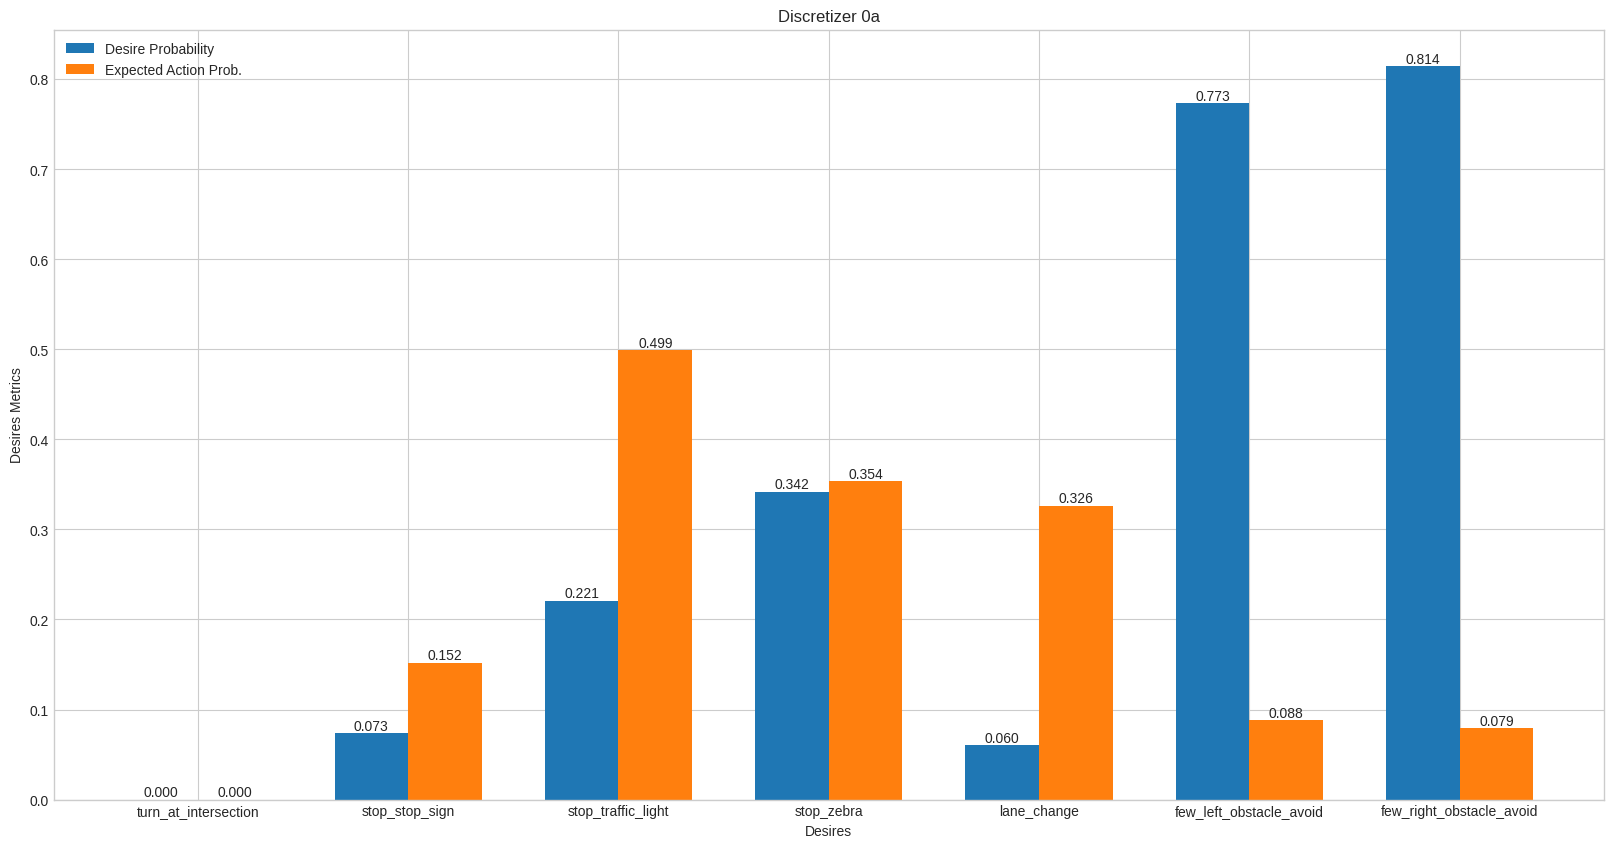

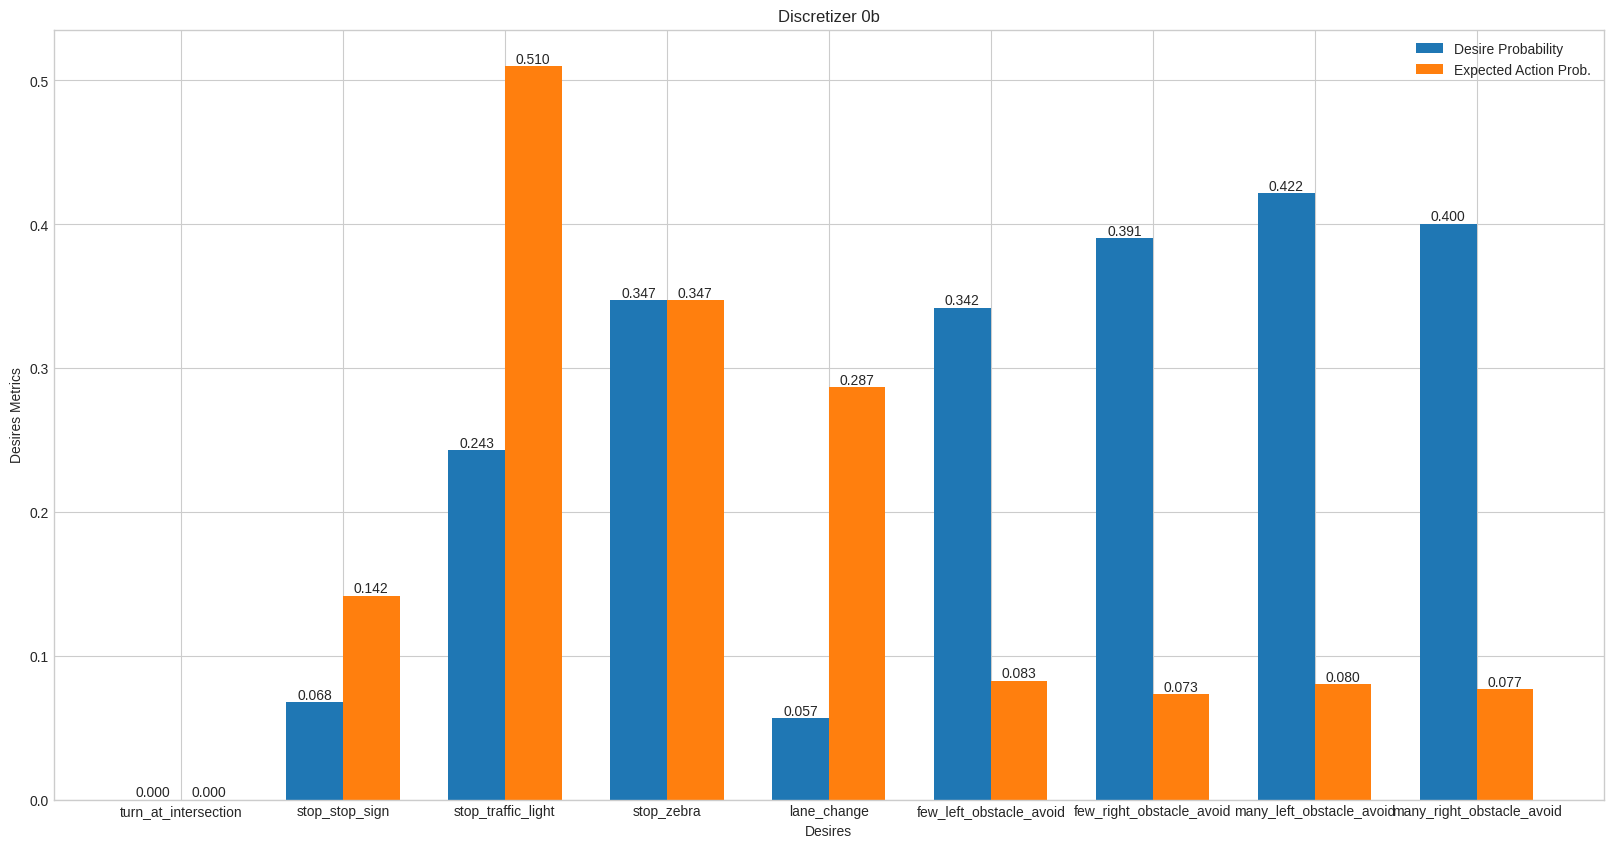

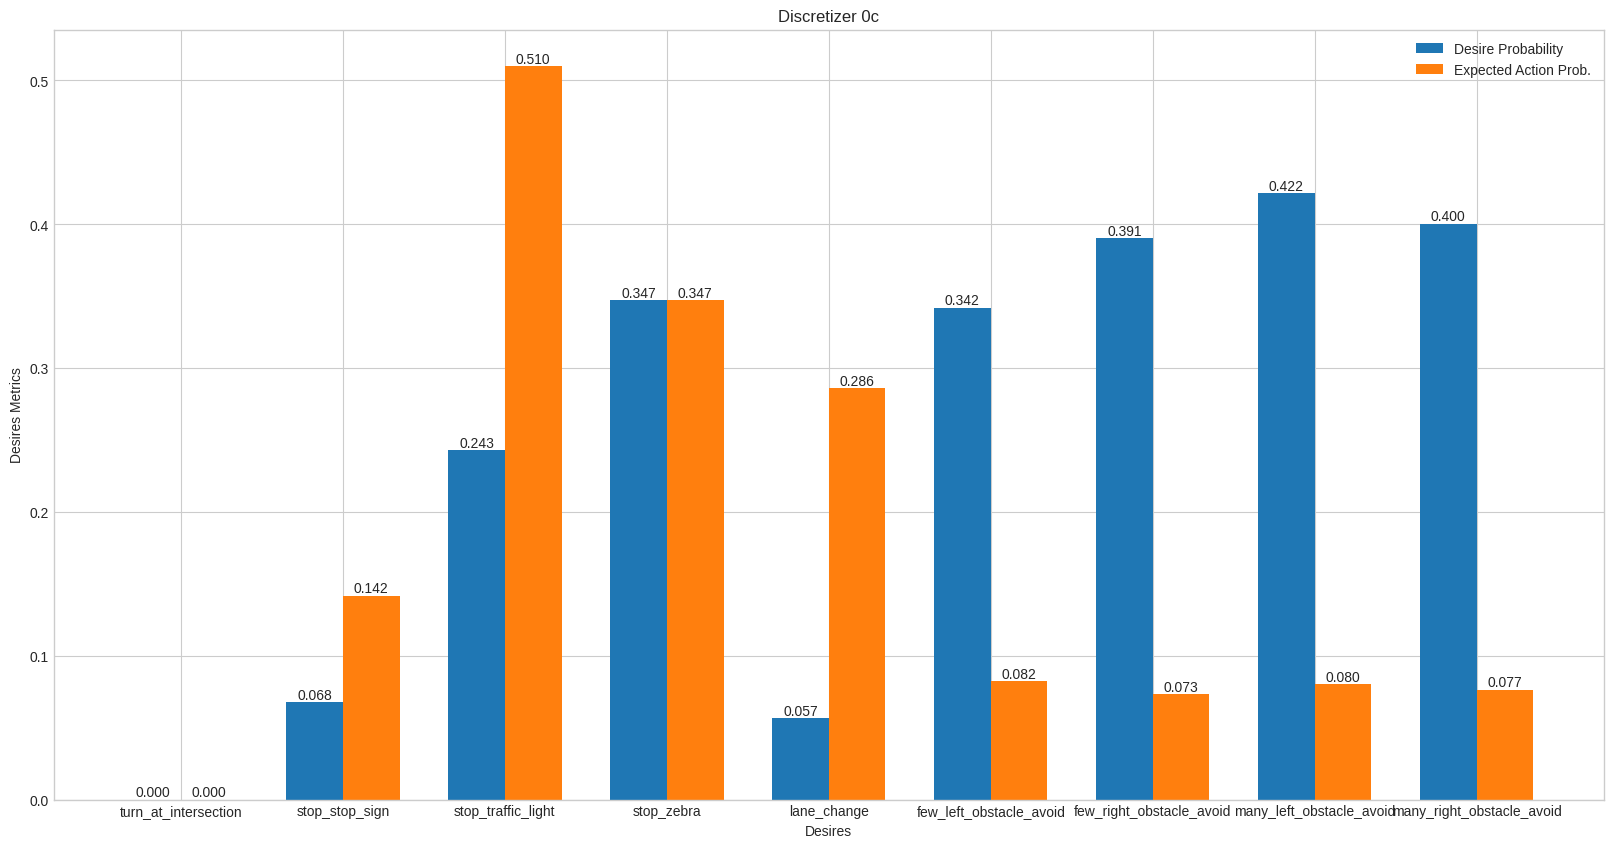

In [13]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')

#### Intentions

posx and posy should be finite values
posx and posy should be finite values


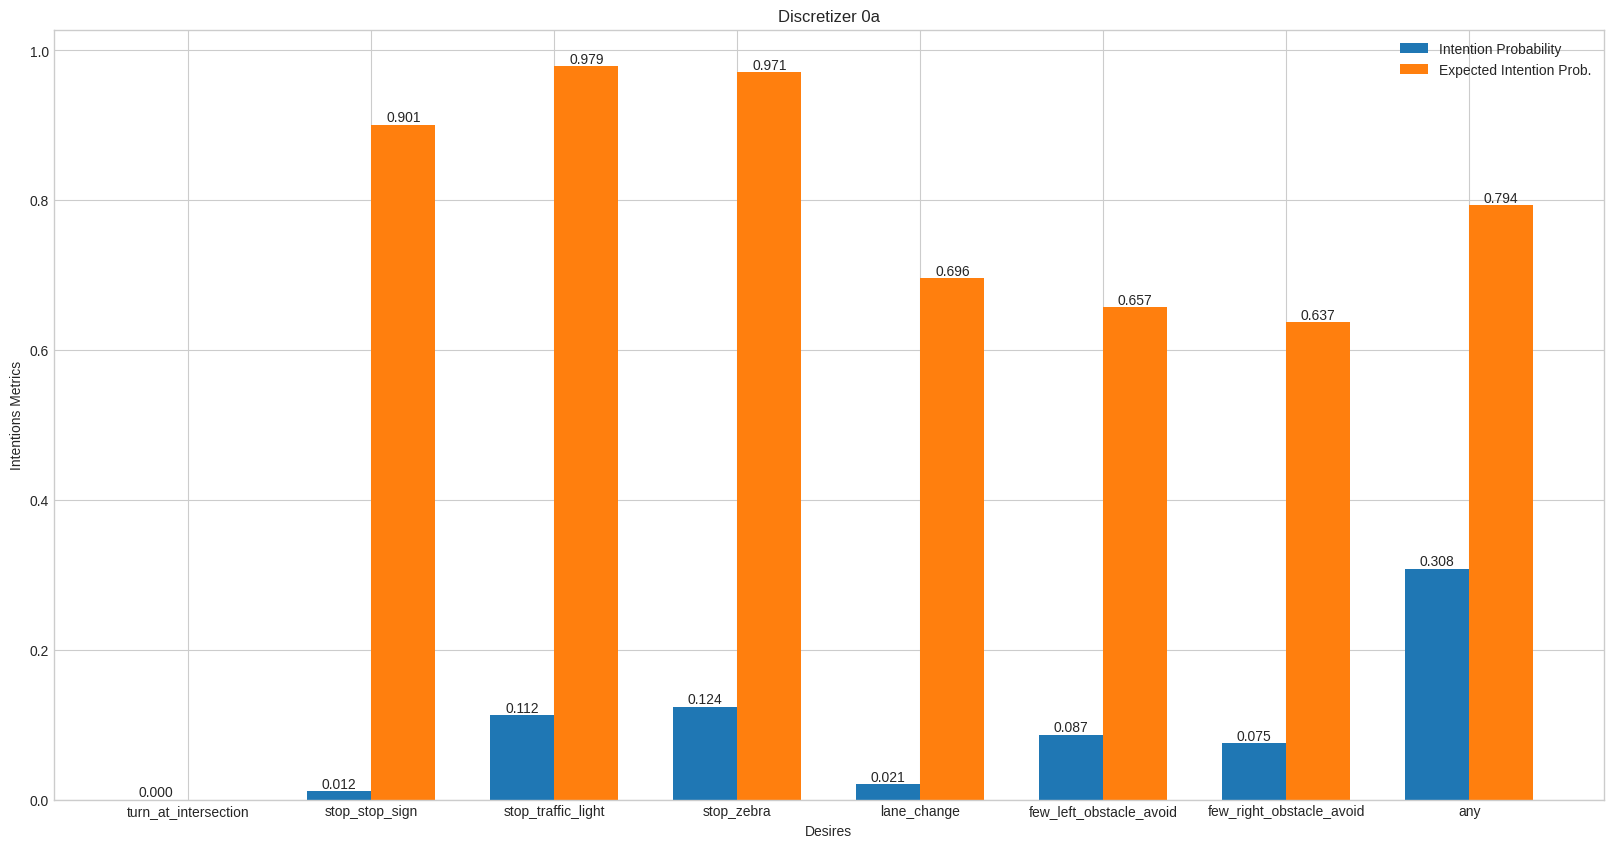

posx and posy should be finite values
posx and posy should be finite values


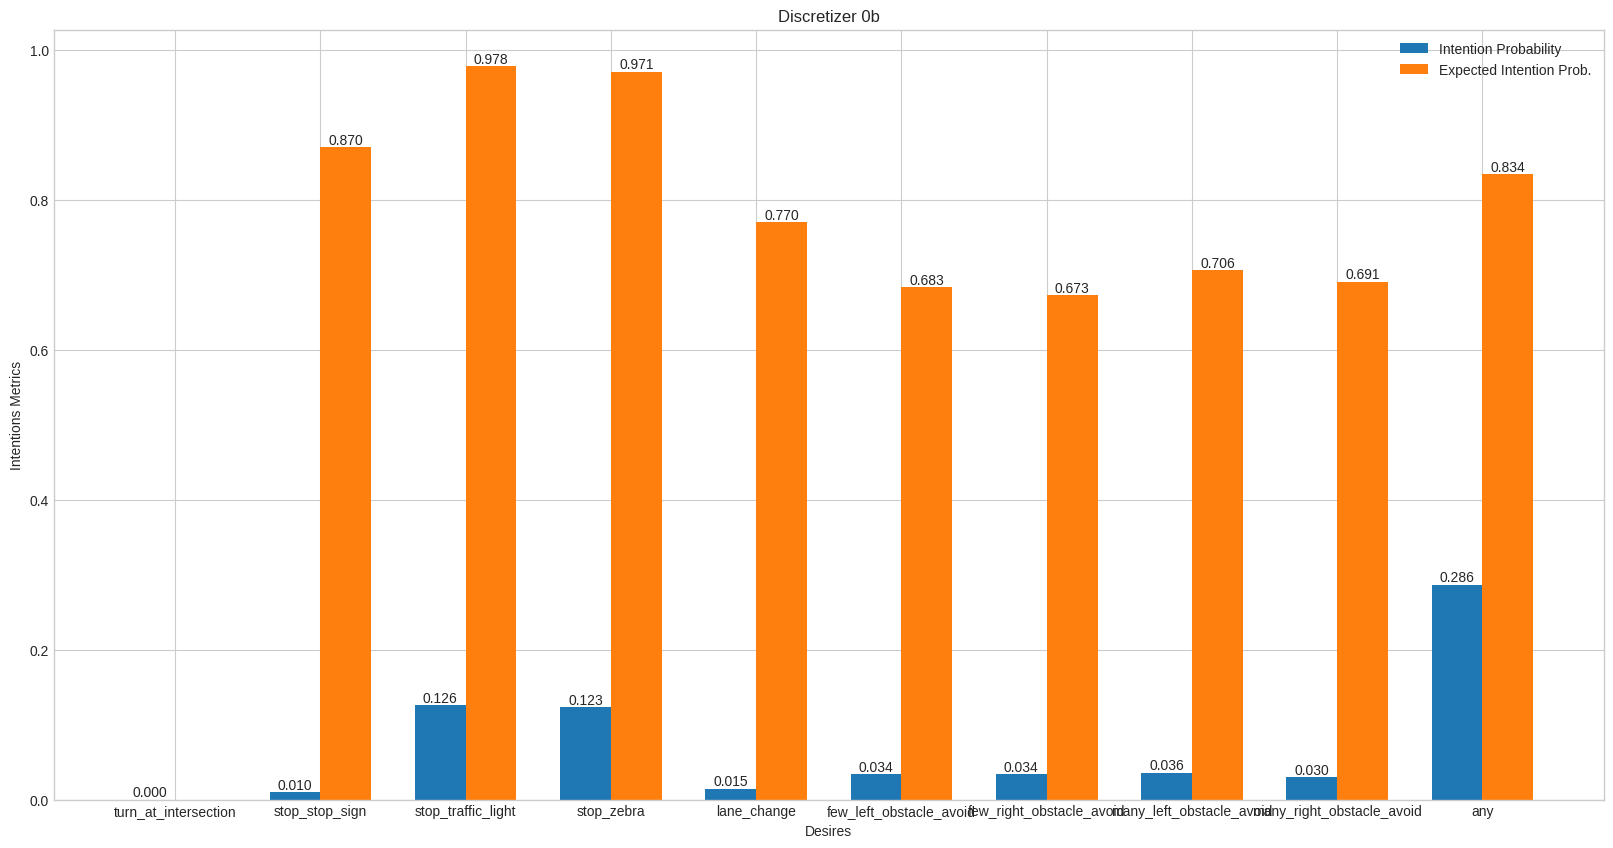

posx and posy should be finite values
posx and posy should be finite values


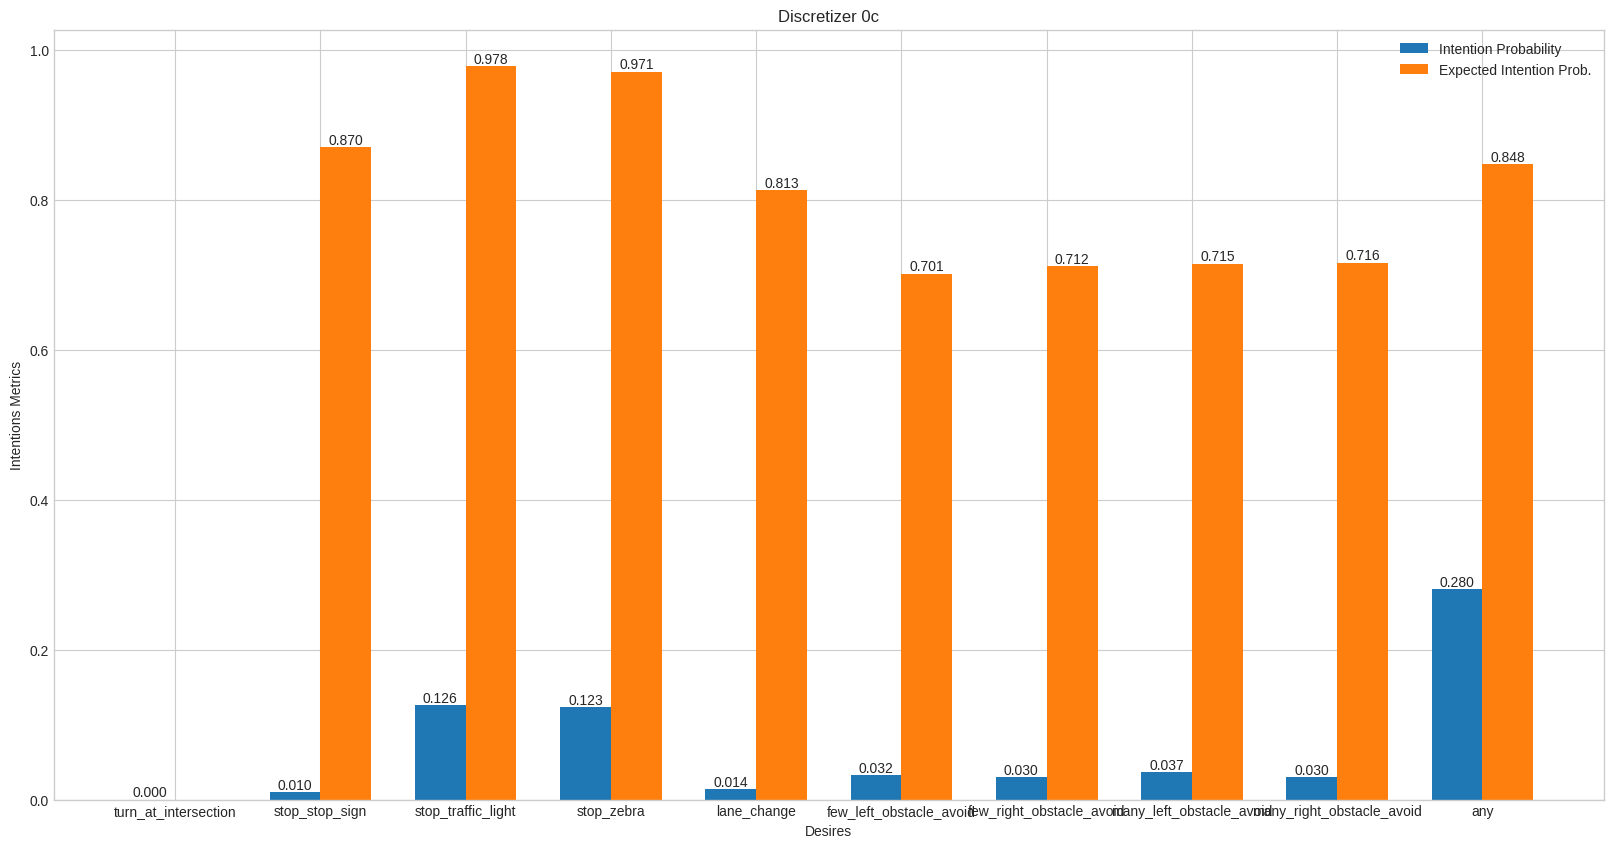

In [14]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

## Discretisers 1a, 1b, 1c

In [16]:
intentions_data = {}
desires_data = {}
for discretizer_id in ['1a','1b','1c']: #
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    discretizer = AVDiscretizerD1(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
        ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    print(f'DISCRETIZER {discretizer_id} ')
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    obstacle_avoidance_l = Desire("few_left_obstacle_avoid", [3, 7], {Predicate(FrontLeftObjects, [FrontLeftObjects(1, discretization=config['obj_discretizer'])]) })
    obstacle_avoidance_r = Desire("few_right_obstacle_avoid", [2, 8], {Predicate(FrontRightObjects, [FrontRightObjects(1,discretization=config['obj_discretizer'])])})

    desires = [turn_at_intersection, stop_stop_sign, stop_traffic_light, stop_zebra, lane_change, obstacle_avoidance_l, obstacle_avoidance_r]

    if 'a' not in discretizer_id:
        desires.append(Desire("many_left_obstacle_avoid", [3, 7], {Predicate(FrontLeftObjects, [FrontLeftObjects(4, discretization=config['obj_discretizer'])]) }) )
        desires.append(Desire("many_right_obstacle_avoid", [2, 8], {Predicate(FrontRightObjects, [FrontRightObjects(4,discretization=config['obj_discretizer'])])})  )
        #desires.append(Desire("stop_zebra", [1], {Predicate(IsZebraNearby, [IsZebraNearby.YES]), Predicate(PedestrianNearby, [PedestrianNearby('1-3')])})) #TODO
    #else:
         #desires.append(Desire("stop_zebra", [1], {Predicate(IsZebraNearby, [IsZebraNearby.YES]), Predicate(PedestrianNearby, [PedestrianNearby('YES')])}) ) #TODO


    
    ii = IntentionIntrospector(desires, pg)

    desires_data[discretizer_id] = ii.find_desires() 
    print(desires_data[discretizer_id])
    intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
    intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
    print(intentions_data[discretizer_id])
    print()

DISCRETIZER 1a 
{'turn_at_intersection': (0.259092680879134, 0.26657603081133846), 'stop_stop_sign': (0.06797397379388923, 0.14180919020793772), 'stop_traffic_light': (0.24302119876465472, 0.5098788957029813), 'stop_zebra': (0.34715600731612245, 0.3475129764142899), 'lane_change': (0.056639980810170604, 0.2874192027743249), 'few_left_obstacle_avoid': (0.7636352733051482, 0.08130968046647177), 'few_right_obstacle_avoid': (0.7909807801865011, 0.07490762807280534)}
{'turn_at_intersection': (0.08131690204191777, 0.7484228737486666), 'stop_stop_sign': (0.0098947557794369, 0.8858710470206422), 'stop_traffic_light': (0.12644298521783454, 0.9770982051223298), 'stop_zebra': (0.12308476507451052, 0.9717819990609255), 'lane_change': (0.013852658091211658, 0.805881636401117), 'few_left_obstacle_avoid': (0.06401607148211448, 0.7334800237493498), 'few_right_obstacle_avoid': (0.05972834397769182, 0.7146626528269712), 'any': (0.29015621720488144, 0.8524995822830462)}

DISCRETIZER 1b 
{'turn_at_interse

### Bar Plots

Desires

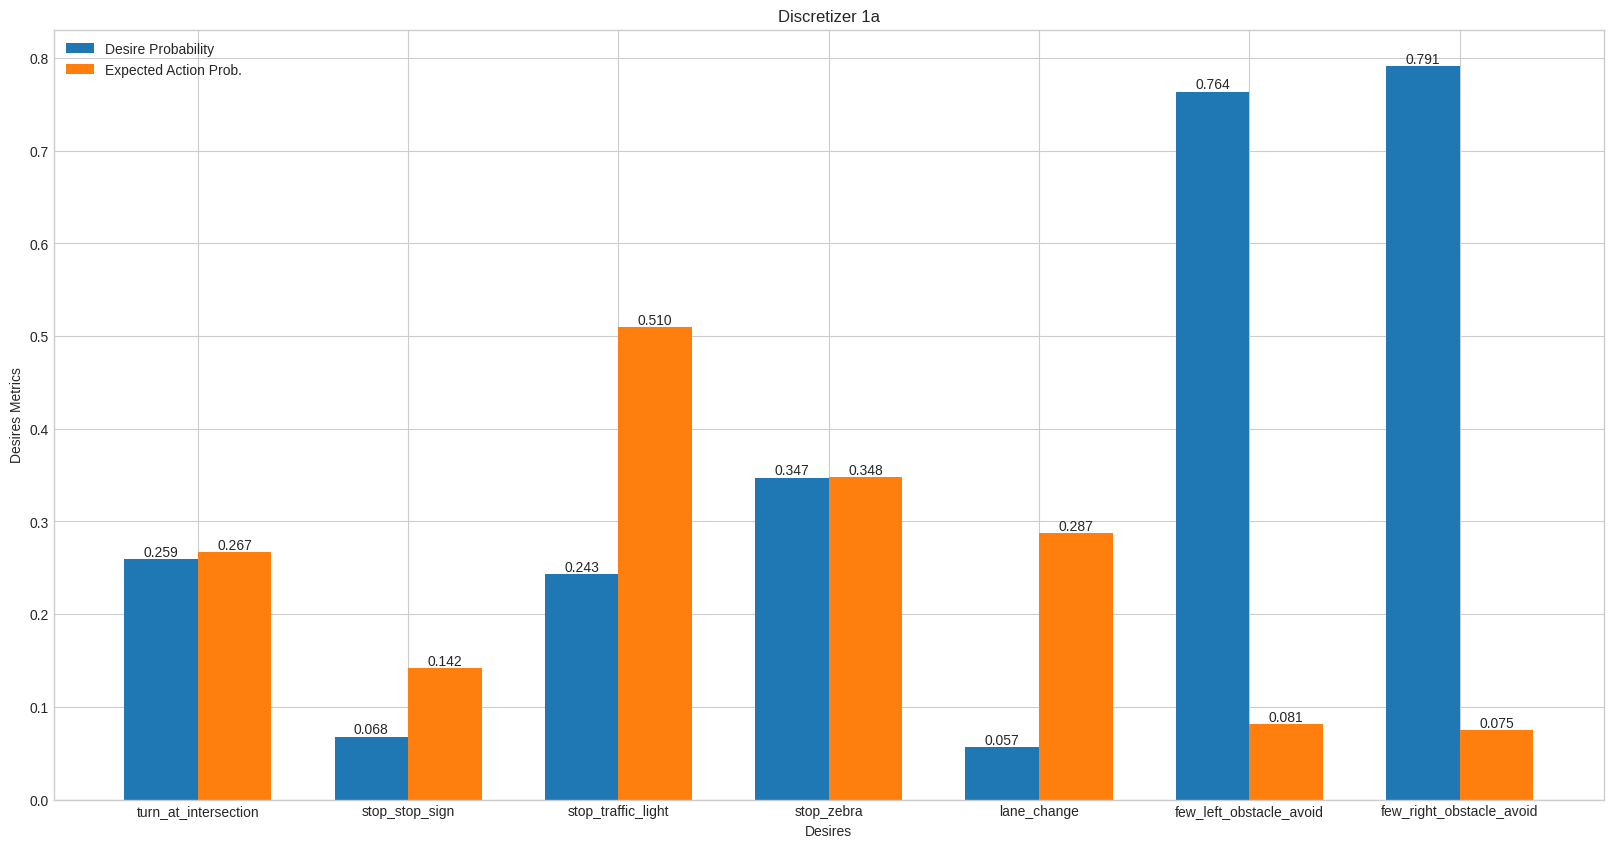

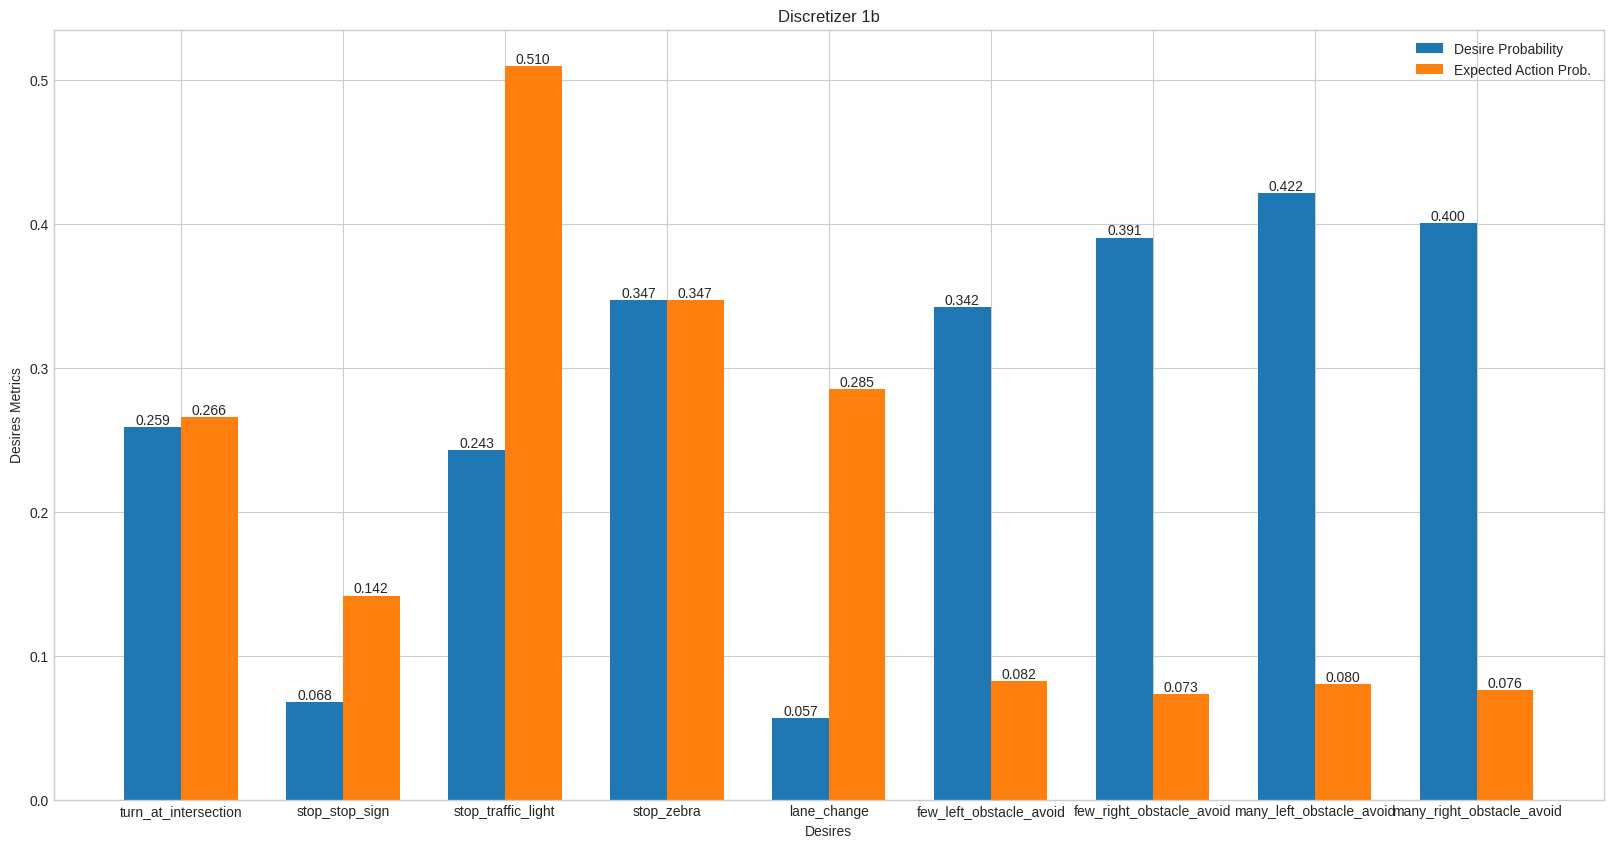

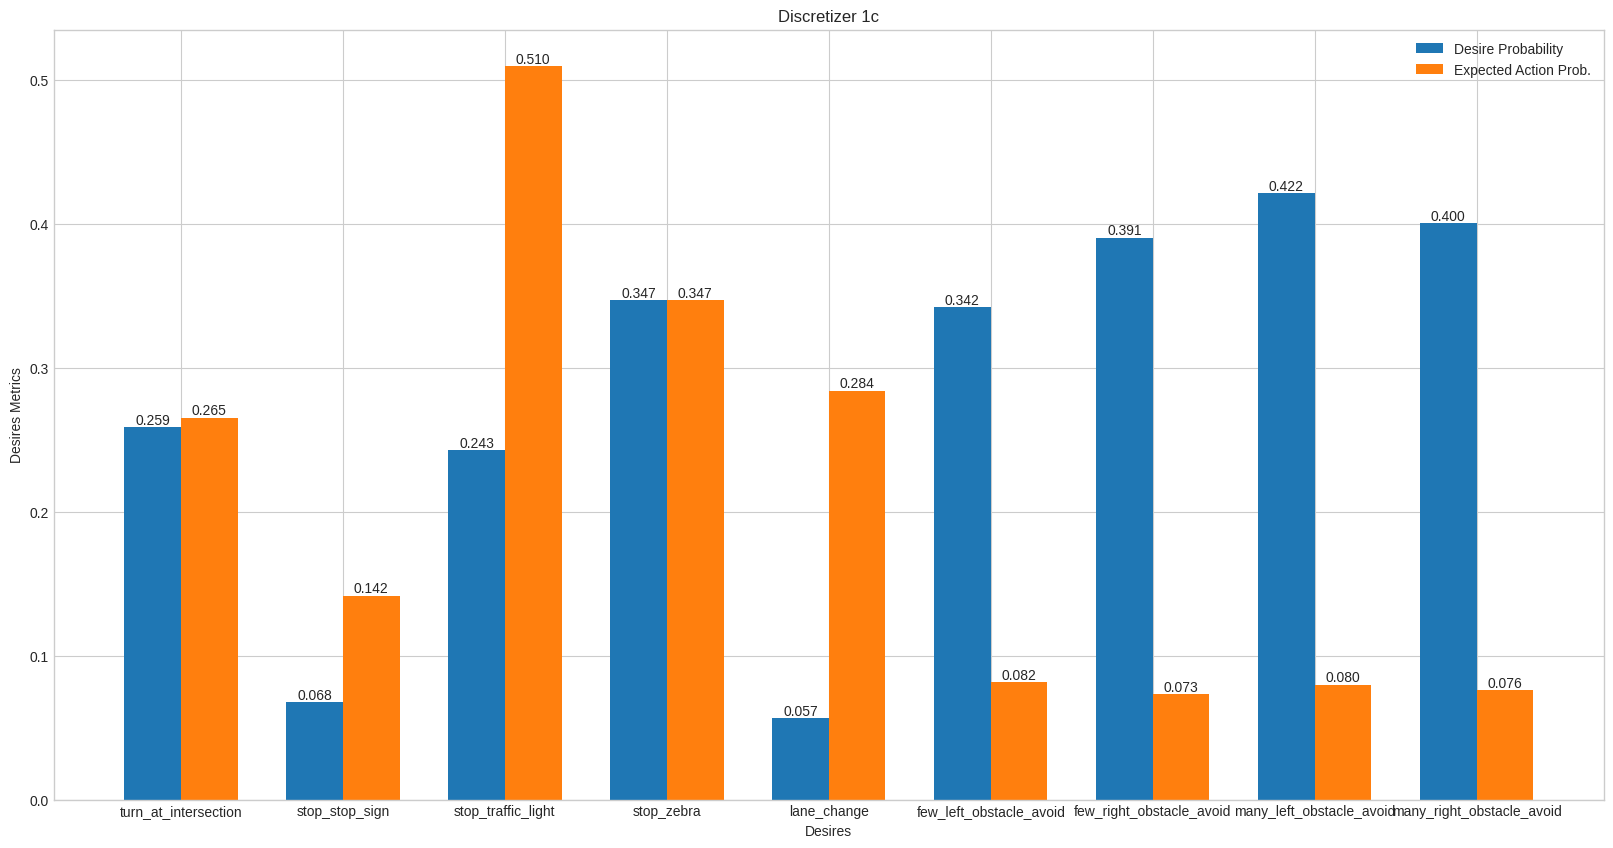

In [17]:
for discretizer in desires_data.keys():
    show_metrics(desires_data[discretizer], discretizer, type = 'Desire')

Intentions

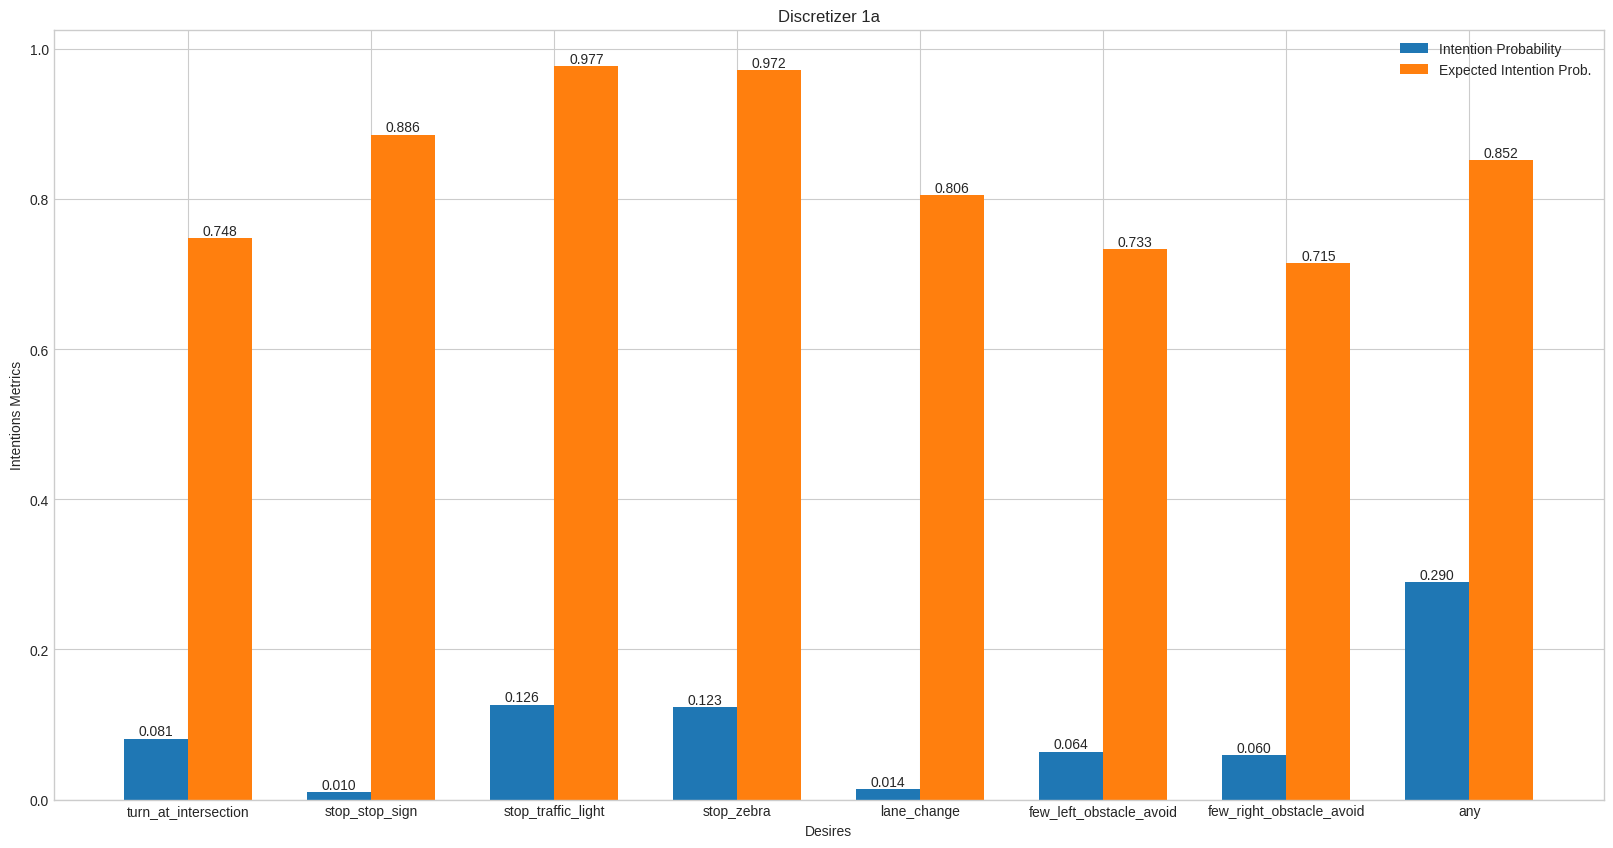

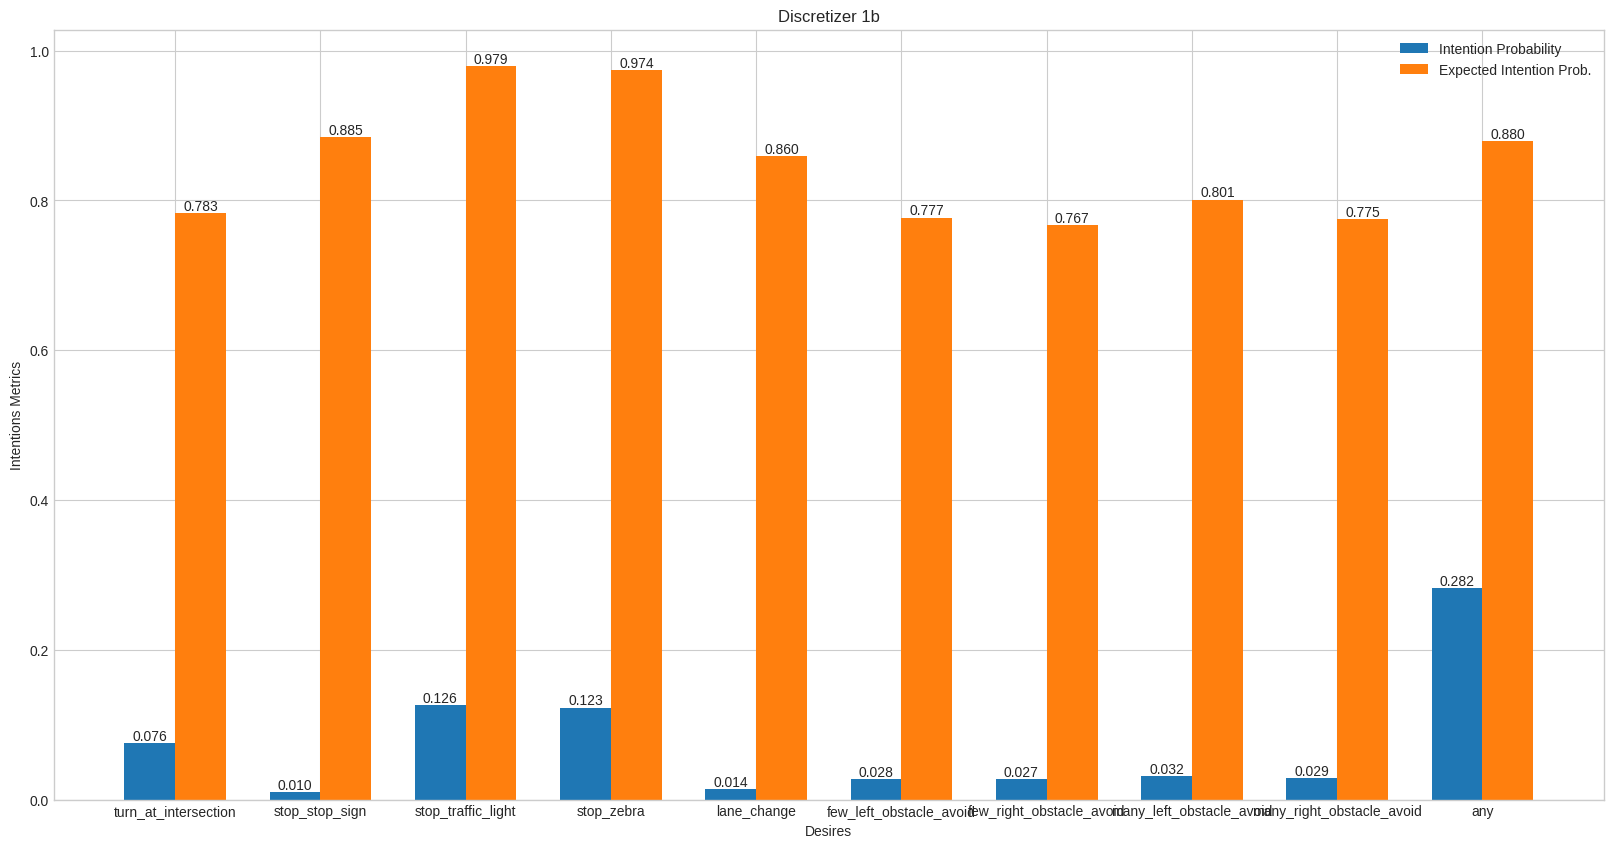

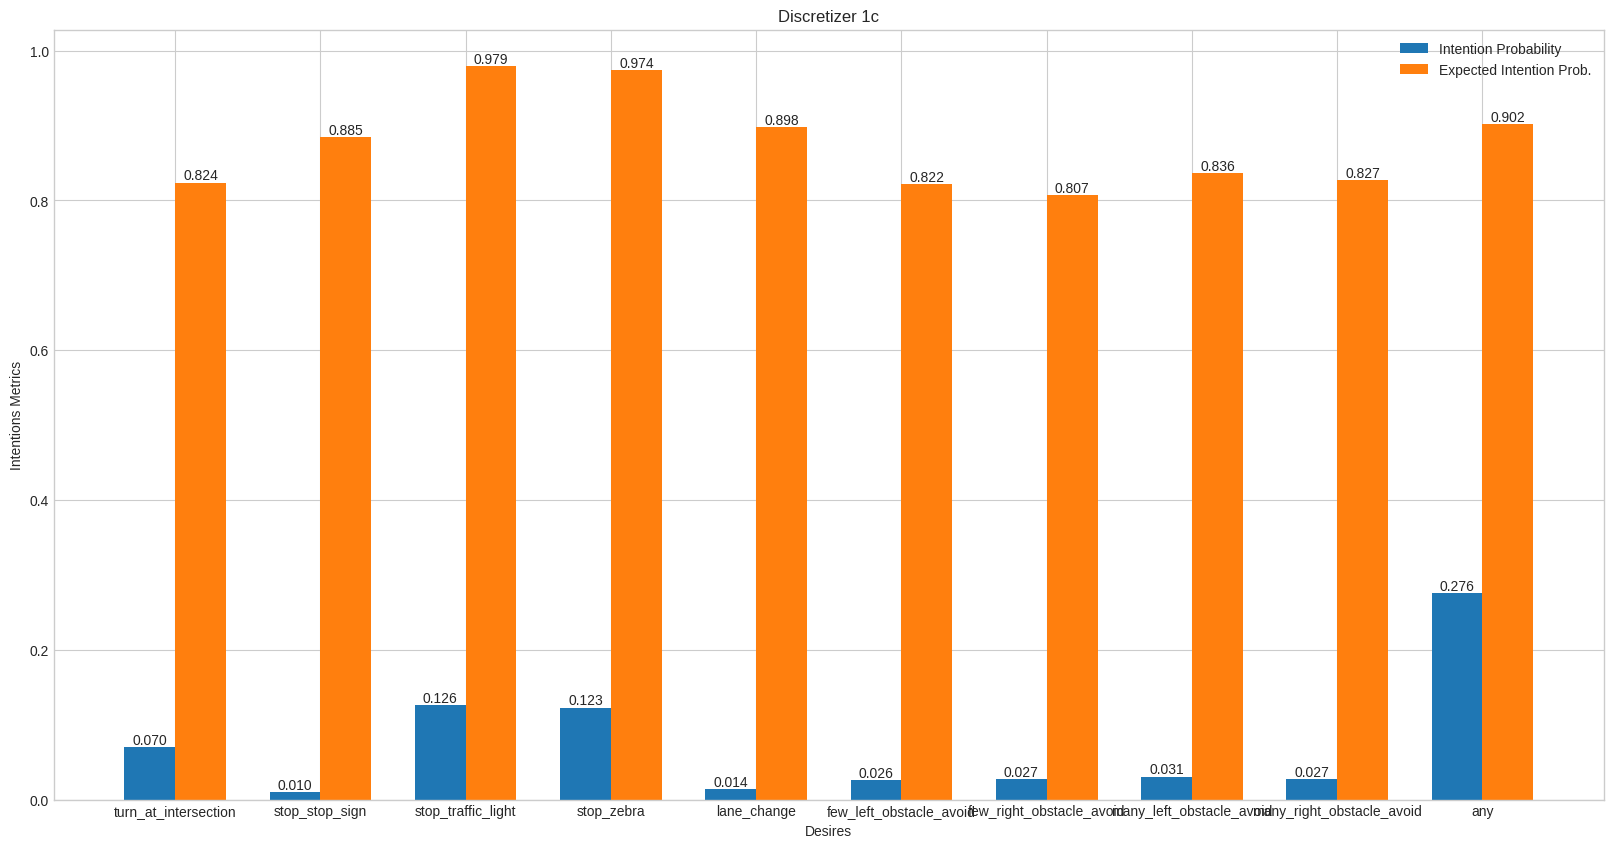

In [18]:
for discretizer in intentions_data.keys():
    show_metrics(intentions_data[discretizer], discretizer, type = 'Intention')

## ROC Curve


Choose the discretiser with higher AIC, that is, the discretiser where the interpretability vs reliability trade-off is better

- If there is no commitment threshold in which the two metrics are decently high, it becomes apparent that the desires do not capture the agent’s behaviour. This can be either because the agent did not train correctly (making the hypothesised desires something it cannot reach) or because the agent is targeting a different set of desires. Our case is the latter. 

- The probability of manifesting intentions is low. the behaviour is not interpretable with these desires, and new ones should be considered.


After seeing seeing this, we added new desires related to OBSTACLE AVOIDANCE, which improved the AUC  for discretisers D0b and D0c.

In [23]:
discretizers_info = {}
for discretizer_id in ['1c']:#'0a','0b','0c','1a','1b','1c']:
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1
    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
            ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    
    
    obstacle_avoidance_l = Desire("few_left_obstacle_avoid", [3, 7], {Predicate(FrontLeftObjects, [FrontLeftObjects(1, discretization=config['obj_discretizer'])]) })
    obstacle_avoidance_r = Desire("rfew_ight_obstacle_avoid", [2, 8], {Predicate(FrontRightObjects, [FrontRightObjects(1,discretization=config['obj_discretizer'])])})
    desires = [turn_at_intersection, stop_stop_sign, stop_traffic_light, stop_zebra, lane_change, obstacle_avoidance_l, obstacle_avoidance_r]

    if 'a' not in discretizer_id:
        desires.append(Desire("many_left_obstacle_avoid", [3, 7], {Predicate(FrontLeftObjects, [FrontLeftObjects(4, discretization=config['obj_discretizer'])]) }) )
        desires.append(Desire("many_right_obstacle_avoid", [2, 8], {Predicate(FrontRightObjects, [FrontRightObjects(4,discretization=config['obj_discretizer'])])})  )

    #if '1' in discretizer_id:
        #desires.append(turn_at_intersection) 
    discretizers_info[discretizer_id] = (pg, desires)


In [ ]:
roc_curve(discretizers_info)

In [22]:
intention_probabilities, expected_probabilities

NameError: name 'intention_probabilities' is not defined